Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan
#gr(size=(600,600));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight]);
df2[:weight_c] = df2[:weight] .- mean_weight;
first(df2, 5)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:2
└ @ Core string:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:3
└ @ Core string:3
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at string:3
└ @ Core string:3


,height,weight,age,male,weight_c
,Float64,Float64,Float64,Int64,Float64
1,151.765,47.8256,63.0,1,2.83512
2,139.7,36.4858,63.0,0,-8.50468
3,136.525,31.8648,65.0,0,-13.1256
4,156.845,53.0419,41.0,1,8.05143
5,145.415,41.2769,51.0,0,-3.71361


Define the Stan language model

In [5]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchains.

In [6]:
stanmodel = Stanmodel(name="weights", model=weightsmodel,
  output_format=:mcmcchains);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.stan will be updated.



Input data for cmdstan

In [7]:
heightsdata = Dict("N" => length(df2[:height]), "height" => df2[:height], "weight" => df2[:weight_c]);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1


Sample using cmdstan

In [8]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);

Describe the draws

In [9]:
MCMCChains.describe(chn)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼──────────┼───────────┼─────────────┼─────────────┤
│ 1   │ alpha      │ 154.597  │ 0.270909  │ 0.00428345  │ 0.00454567  │
│ 2   │ beta       │ 0.905121 │ 0.0428364 │ 0.000677304 │ 0.000489992 │
│ 3   │ sigma      │ 5.10219  │ 0.193141  │ 0.00305382  │ 0.00326633  │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ alpha      │ 154.072  │ 154.414  │ 154.598  │ 154.778  │ 155.133  │
│ 2   │ beta       │ 0.822281 │ 0.875804 │ 0.905262 │ 0.934394 │ 0.991008 │
│ 3   │ sigma      │ 4.74712  │ 4.96729  │ 5.0965   │ 5.23005  │ 5.50202  │


Plot the density of posterior draws

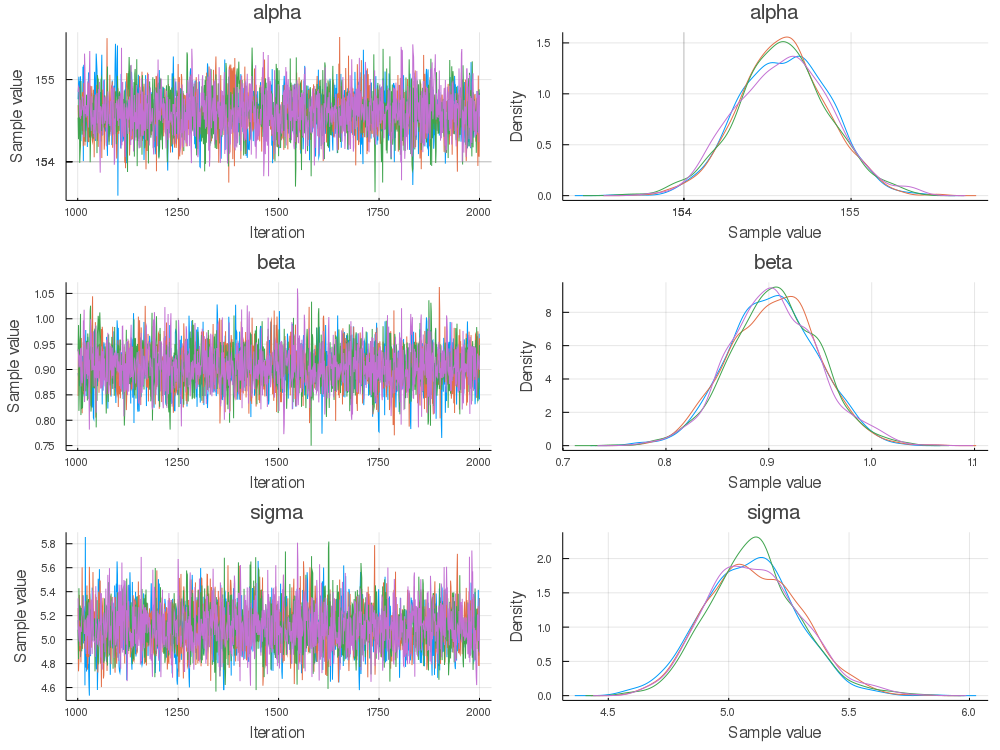

In [10]:
plot(chn)

Plot regression line using means and observations

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at string:1
└ @ Core string:1


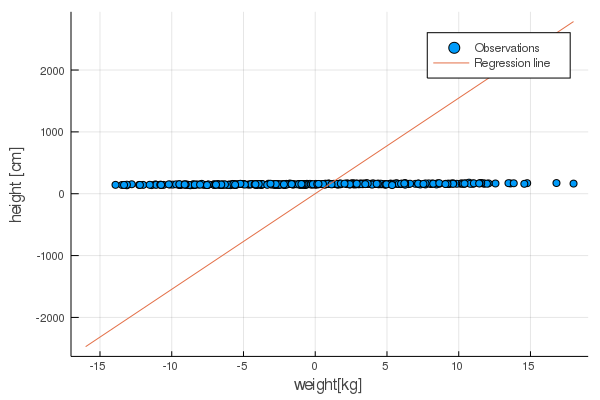

In [11]:
scatter(df2[:weight_c], df2[:height], lab="Observations",
  ylab="height [cm]", xlab="weight[kg]")
xi = -16.0:0.1:18.0
rws, vars, chns = size(chn)
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)));
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)));
yi = mean(alpha_vals) .+ mean(beta_vals)*xi;
plot!(xi, yi, lab="Regression line")

End of `clip-43s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*